# Annotation Analysis | Hypothesis | SFU Courses

In [12]:
import configparser
import datetime
import json
import re
from statistics import mean, median
from pathlib import Path

from tabulate import tabulate
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import requests

In [91]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_palette("Paired")

savefigs = False

URL_PATTERN = "((http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?)"

data_dir = Path("../data")
plot_dir = Path("../plots")

groups_file = data_dir / "groups.csv"
comments_file = data_dir / "comments.csv"
readings_file = data_dir / "readings.csv"

## Load and process data

In [223]:
groups = pd.read_csv(str(groups_file))
comments = pd.read_csv(str(comments_file), index_col="id", parse_dates=['created', 'updated'])
readings = pd.read_csv(str(readings_file), index_col="id", parse_dates=['date'])

# Join actual comments with some info from the readings
comments = comments.merge(readings[['url', 'course', 'date', 'instructor']], left_on="reading_id", right_index=True)

In [224]:
comments = comments[comments.created>pd.Timestamp(datetime.date(2019, 1, 1))]

In [225]:
# Create some extra metrics for individual comments
comments['length'] = comments.text.map(lambda x: len(str(x)))
comments['created_day'] = comments.created.map(lambda x: datetime.datetime(year=x.year, month=x.month, day=x.day))
comments['Has URL'] = comments.text.map(lambda x: re.search(URL_PATTERN, x) is not None if not pd.isna(x) else None)

comments.course.value_counts()

PUB 802     1876
GERO 411     136
CMNS 432      60
Name: course, dtype: int64

In [244]:
courses_to_include = ["PUB 802"]

comments = comments[comments.course.isin(courses_to_include)]
readings = readings[readings.course.isin(courses_to_include)]

In [241]:
readings['month'] = readings.date.map(lambda x: x.month)
readings['week'] = readings.date.map(lambda x: x.week)

## Plots & analyses

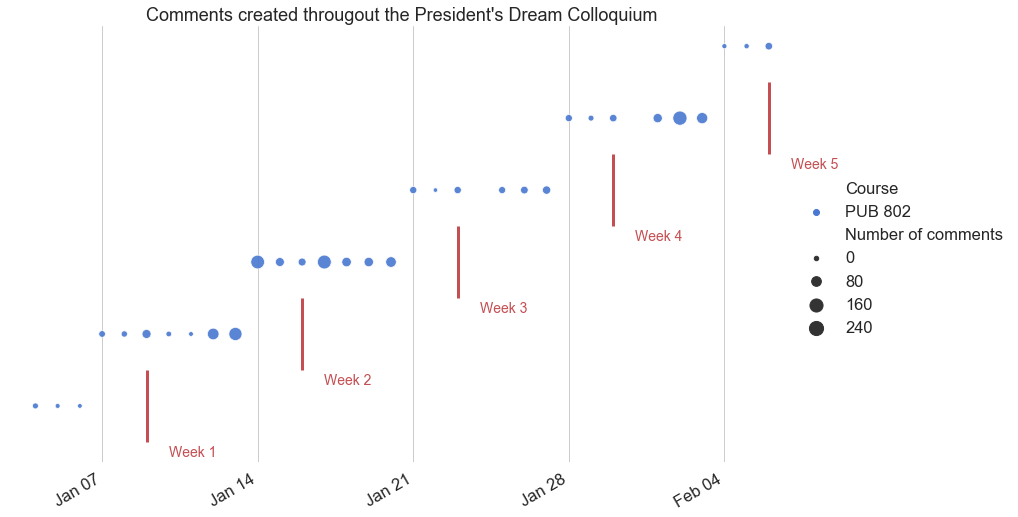

In [245]:
pdf = comments.groupby(["created_day", "week", "course"]).count()['text'].reset_index()
pdf.columns = ['Date', 'Week', "Course", 'Number of comments']

classes = pd.DataFrame(columns=["date"])
classes.date = pd.date_range(start=min(readings.date), end=max(pdf.Date), freq='W-WED')
classes.index.name = week
classes.index = classes.index + 1

# Plot bubbles
g = sns.relplot(x="Date", y="Week", hue="Course", size="Number of comments", alpha=.9,
            sizes=(20,200), palette="muted", data=pdf, height=8, aspect=1.5);
ax = g.facet_axis(0,0)

# Plot class tick marks
for w, date in classes.itertuples(index=True):
    ax.vlines(date, w-.5, w+.5, colors="r", lw=3, alpha=1)
    plt.text(date+pd.Timedelta("1 days"), w-.7, "Week {}".format(w), fontsize=14, color="r")
    
# Formatting
ax.set_xlim((min(pdf.Date)-pd.Timedelta('1 days'), max(pdf.Date)+pd.Timedelta('1 days')));

weekFormatter = mdates.DateFormatter('%b %d');
ax.xaxis.set_major_formatter(weekFormatter);

mondays = mdates.WeekdayLocator(mdates.MONDAY)
ax.xaxis.set_major_locator(mondays)

plt.gcf().autofmt_xdate();

plt.xlabel("")
plt.title("Comments created througout the President's Dream Colloquium")
ax.yaxis.set_visible(False)
sns.despine(right=True, top=True, left=True, bottom=True)

if savefigs:
    plt.savefig(str(plot_dir / "week_overview.png"), bbox_inches="tight")

## Comments per part, week, and readings

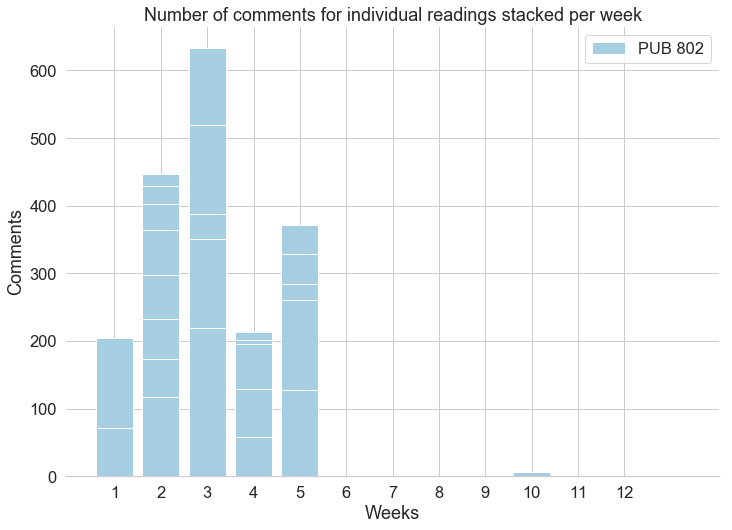

In [189]:
readings_per_week = readings.reset_index().groupby("week")["id"].apply(list)
comments_per_week = comments.groupby("reading_id")["reading_id"].count()

pdf = pd.DataFrame(columns = ["week", "reading", "comments"])
for w, rs in readings_per_week.items():
    for r in rs:
        rel_readings = readings_per_week.loc[w]
        rel_readings = rel_readings[:rel_readings.index(r)+1]
        pdf.loc[len(pdf)+1] = [w, r, comments_per_week.reindex(rel_readings).sum()]

courses = list(comments.course.unique())
c = sns.color_palette(n_colors=len(courses))
colors = {course:col for course, col in zip(courses, c)}

for i, row in pdf[::-1].iterrows():
    reading = int(row['reading'])
    week = row['week']
    course = readings.loc[reading].course
    if course in courses:
        label = course
        courses.remove(course)
    else:
        label = None

    color = colors[course]
    plt.bar(week, row['comments'], color=color, label=label)

plt.ylabel("Comments")    
plt.xlabel("Weeks")
plt.title("Number of comments for individual readings stacked per week")
plt.xticks(range(1, int(max(pdf.week))))

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

sns.despine(right=True, top=True, left=True)

if savefigs:
    plt.savefig(str(plot_dir / "comments_per_reading.png"), bbox_inches="tight")

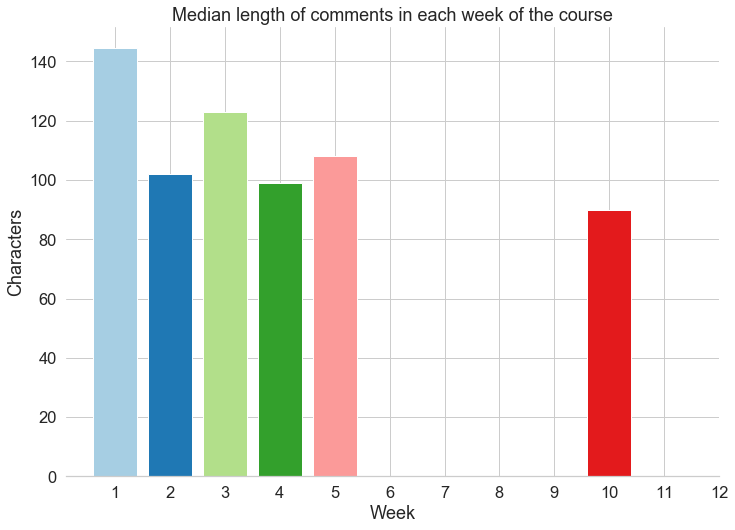

In [190]:
comments_per_week = comments.groupby("week")["length"].median()

months = list(readings.month.unique())
c = sns.color_palette(n_colors=len(months))

for i, l in comments_per_week.iteritems():
    plt.bar(i, l, )

plt.legend()
plt.ylabel("Characters")
plt.xlabel("Week")
plt.title("Median length of comments in each week of the course")
plt.xticks(range(1, 13))

sns.despine(right=True, top=True, left=True)

if savefigs:
    plt.savefig(str(plot_dir / "med_comment_length.png"), bbox_inches="tight")

## Comments and median lenghts

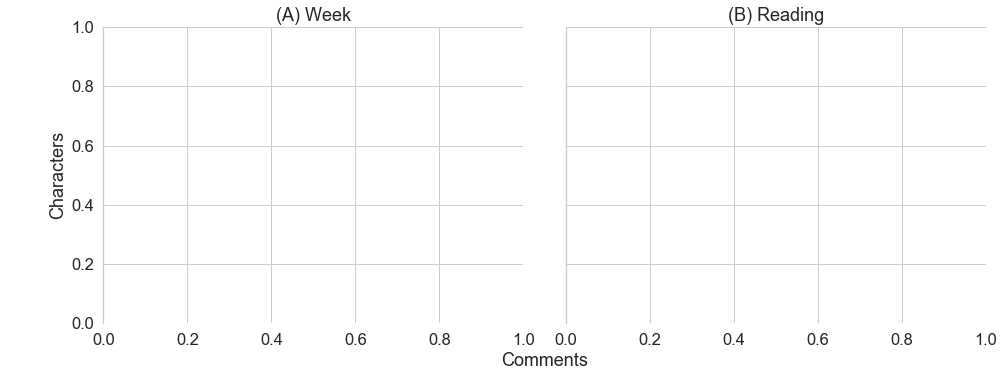

In [100]:
fig, axes = plt.subplots(1,2,figsize=(14,6), sharey=True)

labels = ["(A) Week", "(B) Reading"]
for ax, by, l in zip(axes, ["week", "reading_id"], labels):
    df = pd.DataFrame()
    df['comments'] = comments.groupby(by)["length"].count()
    df['length'] = comments.groupby(by)["length"].median()
    df['course'] = df.index.map(lambda x: comments[comments[by]==x].course.iloc[0]).astype("category")
    
    df.reset_index(inplace=True)
    
    for i in courses:
        pdf = df[df.course == i]
        ax.scatter(pdf['comments'], pdf['length'], s=65, alpha=0.9, label = "{}".format(i))
    
    for i, row in df.iterrows():
        ax.annotate(int(row[by]),
                    (row['comments']+4, row['length']),
                    horizontalalignment='left',
                    verticalalignment='center',
                    size=14)

    ax.set_title(l)   
    ax.set_xlim(0, ax.get_xlim()[1])
    sns.despine(bottom=True, ax=ax)

box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.ylabel("Characters")
plt.xlabel("Comments")

plt.tight_layout()
plt.legend()

if savefigs:
    plt.savefig(str(plot_dir / "comments_vs_length.png"), bbox_inches="tight")

## Parts, weeks, readings per user

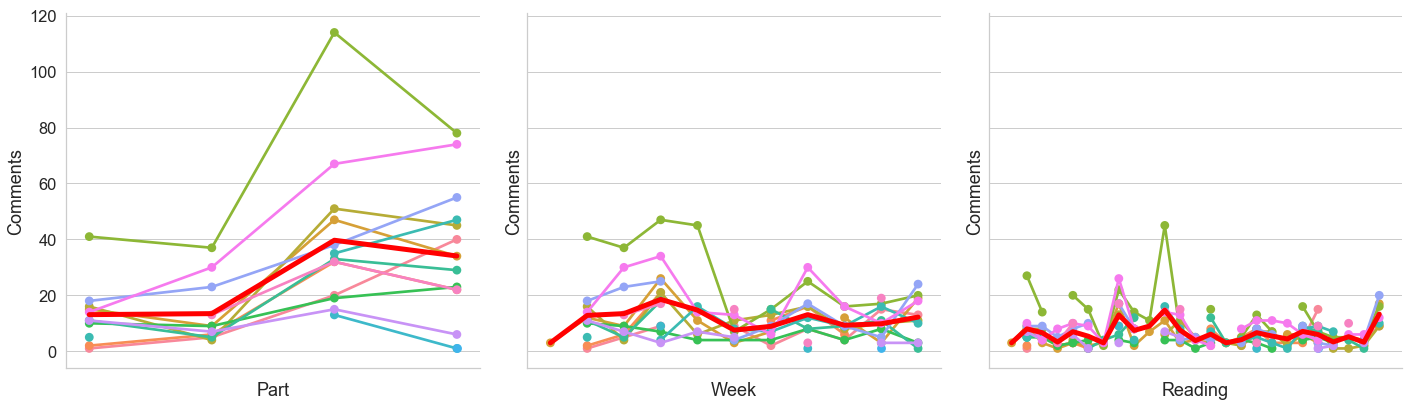

In [247]:
fix, axes = plt.subplots(1,3,figsize=(20,6), sharey=True)
labels = ["Part", "Week", "Reading"]
for ax, by, l in zip(axes, ["part", "week", "url_id"], labels):
    pdf = comments.groupby(["user", by])['text'].count().reset_index()
    sns.pointplot(x=by, y="text", hue="user", data=pdf, ax=ax,  lw=1)
    
    x = pdf.groupby([by]).mean()
    ax.plot(x.text.values, c="red", lw="5", zorder=100)

    ax.legend_.remove()
    ax.set_xlabel(l);
    ax.set_xticklabels([])
    ax.set_ylabel("Comments")
    sns.despine(right=True, top=True, ax=ax)
plt.tight_layout()

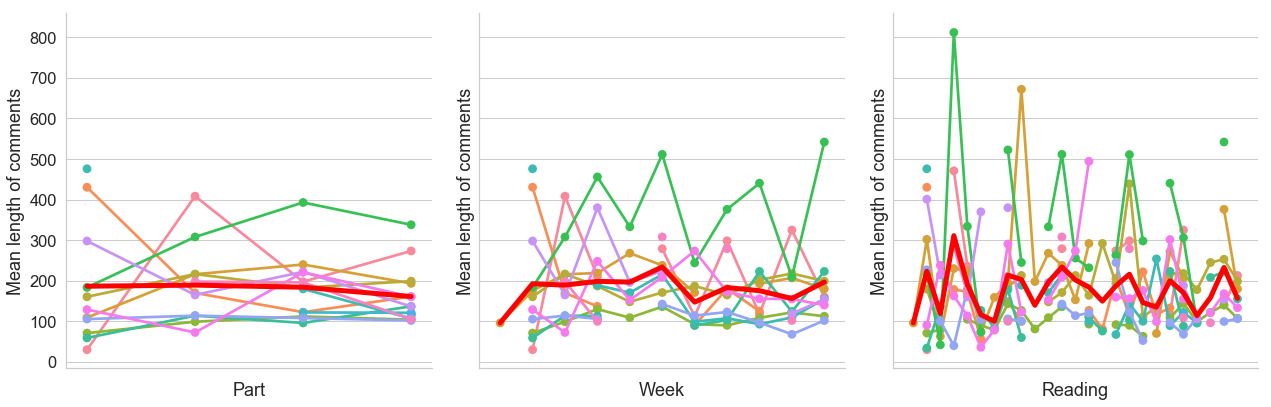

In [248]:
fix, axes = plt.subplots(1,3,figsize=(18,6), sharey=True)
labels = ["Part", "Week", "Reading"]
for ax, by, l in zip(axes, ["part", "week", "url_id"], labels):
    pdf = comments.groupby(["user", by])['length'].median().reset_index()
    sns.pointplot(x=by, y="length", hue="user", data=pdf, ax=ax,  lw=1)
    
    x = pdf.groupby([by]).mean()
    ax.plot(x.length.values, c="red", lw="5", zorder=100)

    ax.legend_.remove()
    ax.set_xlabel(l);
    ax.set_xticklabels([])
    ax.set_ylabel("Mean length of comments")
    sns.despine(right=True, top=True, ax=ax)
plt.tight_layout()

## Number of comments and the median length

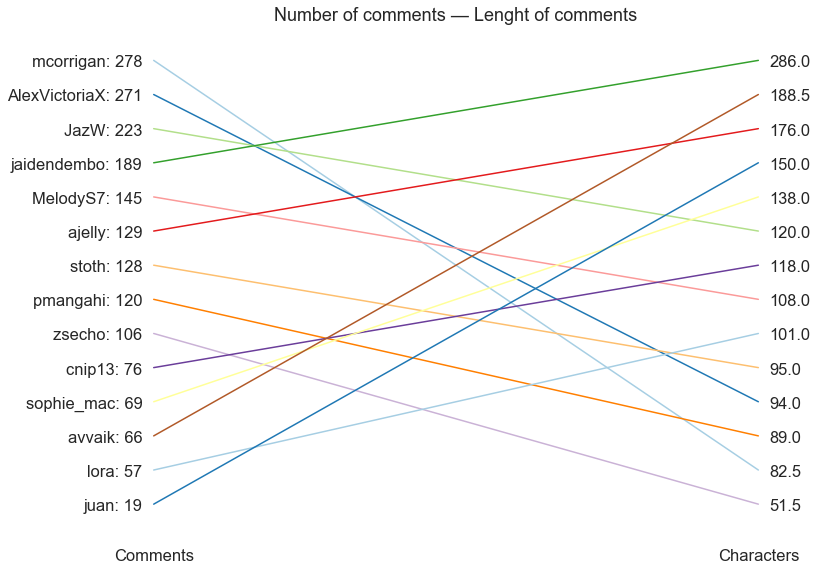

In [203]:
counts = pd.DataFrame(columns=["total", "median"])
counts['total'] = comments.user.value_counts()
counts['median'] = comments.groupby("user")["text"].apply(lambda x: median([len(str(y)) for y in x.tolist()]))
# counts.rank(ascending=False).T.plot(legend=False)

col = sns.color_palette(n_colors=5)
pdf = counts.rank(ascending=False)
labels = []
for i, row in pdf.iterrows():
    plt.plot([row['total'],row['median']])
    labels.append(l)
    
# plt.legend(loc="right")
# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

ax1 = plt.gca()
ax1.set_ylim((0,15))

ax2 = ax1.twinx()
ax2.set_ylim((0,15))

ax1.set_yticks(range(1, 15))
ax2.set_yticks(range(1, 15))

labels_1 = []
for k, v in counts['total'].items():
    labels_1.append("{}: {}".format(k, v))
ax1.set_yticklabels(labels_1)

labels_2 = []
for k, v in counts['median'].sort_values().items():
    labels_2.append("{}".format(v))
ax2.set_yticklabels(labels_2)

ax1.invert_yaxis()

plt.title("Number of comments — Lenght of comments")
plt.xticks([0,1], ["Comments", "Characters"]);
ax1.grid(False)
ax2.grid(False)
ax1.yaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax1.tick_params(axis='y', pad=-25)
ax2.tick_params(axis='y', pad=-25)

# plt.subplots_adjust(hspace=0)

plt.tight_layout()
sns.despine(right=True, top=True, bottom=True, left=True, trim=True)

if savefigs:
    plt.savefig(str(plot_dir / "user_ranks_length_vs_comments.png"), bbox_inches="tight")

### Reading Times

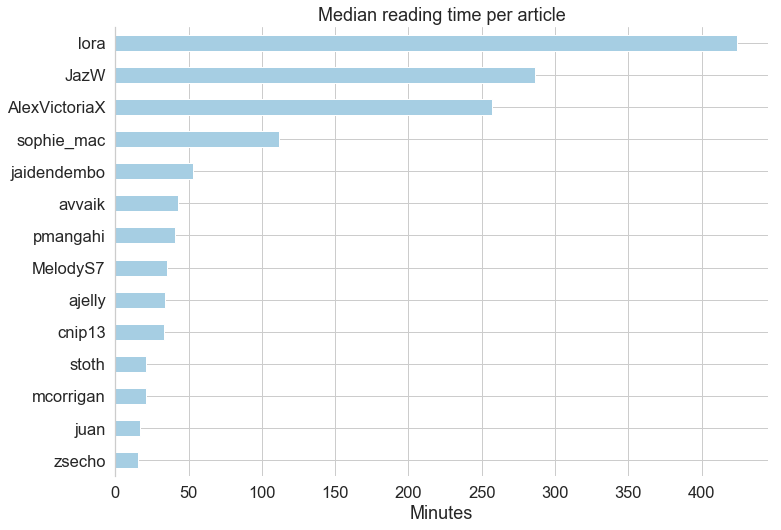

In [210]:
reading_times = pd.DataFrame(columns=["reading_id", "week", "user", "mins", "comments"])
usernames = comments.user.unique()

for user in usernames:
    for uid in comments.reading_id.unique():
        c = comments[(comments.user==user)&(comments.reading_id==uid)]
        count = len(c)
        if count > 1:
            reading_time = max(c.created)-min(c.updated)
            reading_time = int(reading_time.seconds // 60)
            reading_times.loc[len(reading_times)+1] = [uid, c.week.iloc[0], user, reading_time, count]
reading_times.mins = reading_times.mins.astype(int)
reading_times.comments = reading_times.comments.astype(int)

pd.DataFrame(reading_times.groupby("user")['mins'].median()).sort_values(by="mins").plot(kind="barh", legend=False)
plt.title("Median reading time per article")
plt.xlabel("Minutes")
plt.ylabel("")
sns.despine(right=True, top=True, bottom=True)

if savefigs:
    plt.savefig(str(plot_dir / "reading_times.png"), bbox_inches="tight")

## Comments with URLs

What about annotations that link to other material?
Is that a particularly engaging activity?

In [213]:
comments['Has URL'].sum()/len(comments)

0.051705756929637525

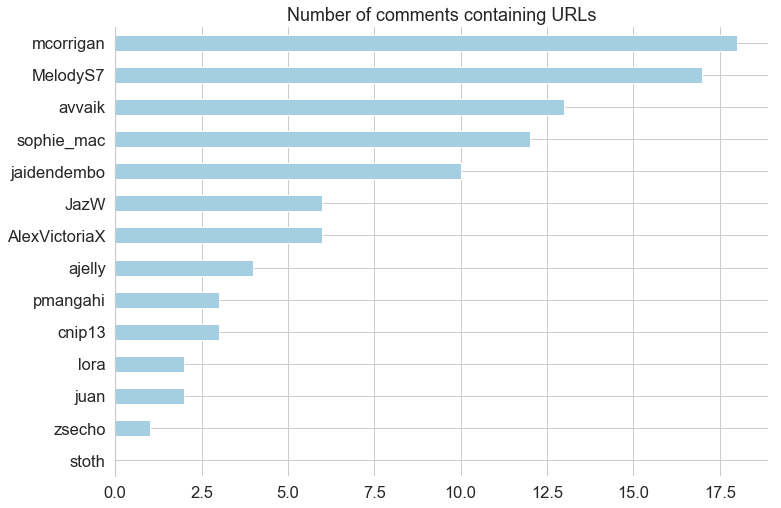

In [214]:
pdf = comments.groupby("user")['Has URL'].apply(lambda x: sum([int(y) if not pd.isna(y) else 0 for y in x]))
pd.DataFrame(pdf).sort_values(by="Has URL").plot(kind="barh", legend=False)
plt.title("Number of comments containing URLs")
plt.ylabel("")
sns.despine(right=True, bottom=True, top=True)

if savefigs:
    plt.savefig(str(plot_dir / "comments_with_urls.png"), bbox_inches="tight")

## Number of comments as a measure of engagement

In [261]:
df = pd.DataFrame(columns=['part', 'survey_part', 'week', 'survey_week', 'reading', 'survey_reading'])
by = "text"

x = comments.groupby(["user", "part"])[by].count().reset_index()
df['part'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['part']

x = comments.groupby(["user", "week"])[by].count().reset_index()
df['week'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['week']

x = comments.groupby(["user", "url_id"])[by].count().reset_index()
df['reading'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['url_id']

df['survey_part'] = eng_survey['eng_part']
df['survey_week'] = eng_survey['eng_week']
df['survey_reading'] = eng_survey['eng_reading']
df = df.dropna()

cols = ["part", "week", "reading"]
matches = pd.DataFrame(columns=cols)
for c in cols:
    for i in df.index.tolist():
        if not pd.isna(df.loc[i, c]) and not pd.isna(df.loc[i, "survey_" + c]):
            survey_max = df.loc[i,"survey_" + c]
            if c=="reading":
                d = "url_id"
            else:
                d = c
            ranks = comments.groupby(["user", d])['text'].count()[i].rank(ascending=False)
            if survey_max in ranks:
                pos = ranks.loc[survey_max]
            else:
                pos = len(ranks)
            matches.loc[i, c] = pos
        else:
            matches.loc[i, c] = None
matches_count = matches

## Length of comments as engagement

In [262]:
df = pd.DataFrame(columns=['part', 'survey_part', 'week', 'survey_week', 'reading', 'survey_reading'])

by = "length"
x = comments.groupby(["user", "part"])[by].mean().reset_index()
df['part'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['part']

x = comments.groupby(["user", "week"])[by].mean().reset_index()
df['week'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['week']

x = comments.groupby(["user", "url_id"])[by].mean().reset_index()
df['reading'] = x.groupby("user").apply(lambda x: x.loc[x[by].idxmax()])['url_id']

df['survey_part'] = eng_survey['eng_part']
df['survey_week'] = eng_survey['eng_week']
df['survey_reading'] = eng_survey['eng_reading']
df = df.dropna()

cols = ["part", "week", "reading"]
matches = pd.DataFrame(columns=cols)
for c in cols:
    for i in df.index.tolist():
        if not pd.isna(df.loc[i, c]) and not pd.isna(df.loc[i, "survey_" + c]):
            survey_max = df.loc[i,"survey_" + c]
            if c=="reading":
                d = "url_id"
            else:
                d = c
            ranks = comments.groupby(["user", d])['length'].mean()[i].rank(ascending=False)
            if survey_max in ranks:
                pos = ranks.loc[survey_max]
            else:
                pos = len(ranks)
            matches.loc[i, c] = pos
        else:
            matches.loc[i, c] = None
matches_length = matches

In [199]:
x = readings[['title', 'type', 'author', 'url', 'total']]
x.columns = ["Title", "Type", "Authors", "URL", "Comments"]
x.index.name = ""
print(tabulate(x, tablefmt="pipe", headers="keys"))

KeyError: "['type' 'author' 'total'] not in index"

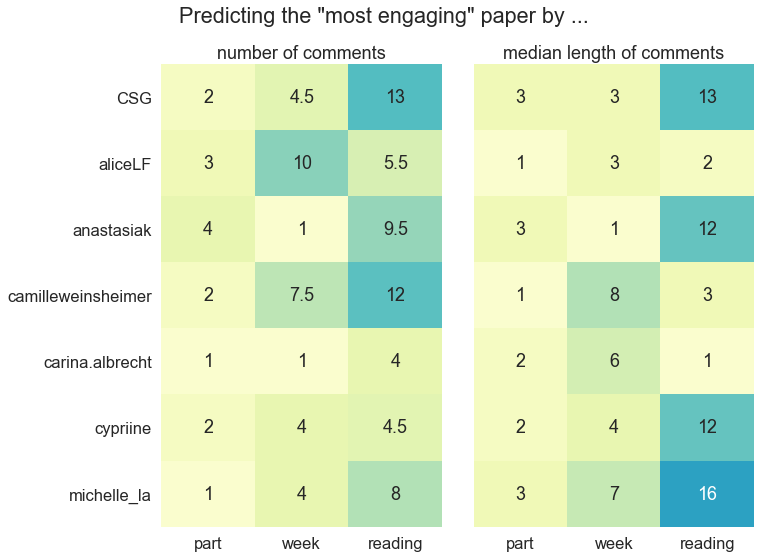

In [266]:
fig, axes = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,8))
titles = ["number of comments", "median length of comments"]
for ax, pdf, t in zip(axes, [matches_count, matches_length], titles):
    pdf = pdf.astype(float).dropna()
    sns.heatmap(data=pdf.values, vmin=0, vmax=28, annot=True, cbar=False, cmap="YlGnBu", ax=ax)
    ax.set_xticks([0.5,1.5,2.5])
    ax.set_xticklabels(["part", "week", "reading"]);
    ax.set_yticks([i-.5 for i in range(1, len(pdf)+1)])
    ax.set_yticklabels(pdf.index.values, rotation=0);
    ax.set_title(t);
plt.suptitle("Predicting the \"most engaging\" paper by ...");
plt.tight_layout()
plt.gcf().subplots_adjust(top=0.88)

if savefigs:
    plt.savefig(str(plot_dir / "engagement_predictors.png"), bbox_inches="tight")

In [93]:
df = pd.DataFrame.from_dict({"part":4, "week":12, "reading":28}, orient="index", columns=["n"])
df['count_accuracy'] = (df.n-matches_count.mean())/(df.n-1)
df['length_accuracy'] = (df.n-matches_length.mean())/(df.n-1)
df

,n,count_accuracy,length_accuracy
reading,28,0.735450,0.724868
week,12,0.675325,0.675325
part,4,0.619048,0.619048
